# Compare with rouse model

In [28]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.transform.msd as msd
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.msd as plot_msd

import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

#plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
#plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
#plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

fig_width_pt = 479.17036  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inches
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": fig_size
}
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
PATH_EXPERIMENT = "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/8b2b60a0"

## Read and process the data

In [5]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data" / "initial_system.data"
PATHS_TRAJECTORIES = [
    PATH_EXPERIMENT / "data/polymer_relax.out",
    PATH_EXPERIMENT / "data/polymer.out",
]

### Read system

In [6]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system

LammpsSystemData(box=-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi, masses=   mass
1   1.0
2   1.0
3   1.0, atoms=       molecule-ID  type         x         y         z  ix  iy  iz
1                1     1  0.000000  0.000000  0.000000   0   0   0
2                1     1 -0.159927 -0.017451 -0.956566   0   0   0
3                1     2 -0.086992 -0.765936 -0.343908   0   0   0
4                1     2  0.059319  0.029401 -0.879569   0   0   0
5                1     2  0.514538  0.823298 -0.558005   0   0   0
...            ...   ...       ...       ...       ...  ..  ..  ..
31996          500     2 -0.155401 -2.419676 -5.478630   0   0   0
31997          500     2  0.094138 -2.563573 -4.552388   0   0   0
31998          500     2 -0.319976 -2.430868 -3.685325   0   0   0
31999          500     2  0.280073 -3.192872 -3.671499   0   0   0
32000          500     3  0.498631 -4.134986 -3.596971   0   0   0

[32000 rows x 8 columns], angle

### Read and process trajectories

In [7]:
PATH_TRAJECTORY_PROCESSED = PATH_EXPERIMENT / "data" / "processed" / "trajectory_unfolded.csv"
PATH_TRAJECTORY_PROCESSED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/8b2b60a0/data/processed/trajectory_unfolded.csv')

In [8]:
df_trajectory_unfolded = pd.read_csv(PATH_TRAJECTORY_PROCESSED)
df_trajectory_unfolded

,t,id,type,x,y,z,ix,iy,iz,molecule-ID
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1
1,0,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1
2,0,3,2,-0.086992,-0.765936,-0.343908,0,0,0,1
3,0,4,2,0.059319,0.029401,-0.879569,0,0,0,1
4,0,5,2,0.514538,0.823298,-0.558005,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
12863995,4000000,31996,2,2.982360,-2.695660,-1.464700,0,0,0,500
12863996,4000000,31997,2,2.421270,-3.163930,-0.682480,0,0,0,500
12863997,4000000,31998,2,3.361140,-3.131540,-0.473719,0,0,0,500
12863998,4000000,31999,2,3.100990,-2.462170,-1.133760,0,0,0,500


### Read and process ETE

In [9]:
df_ete = pd.read_csv(PATH_ETE, index_col=["molecule-ID", "t"])
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y       R_z          R     t/LJ  \
molecule-ID t                                                            
1           0         5.307310 -4.659180  5.742710   9.102429      0.0   
            10000     9.170240 -1.834770  5.650180  10.926308     25.0   
            20000     9.366530 -4.153510  4.164100  11.059985     50.0   
            30000    10.623800 -1.569500  7.310200  12.991054     75.0   
            40000    13.672000  0.195801  6.500890  15.140129    100.0   
...                        ...       ...       ...        ...      ...   
500         3960000  -0.519303 -3.341520  0.632771   3.440324   9900.0   
            3970000  -1.794660 -2.027290 -2.750260   3.859357   9925.0   
            3980000   0.063573 -1.570330 -1.300130   2.039685   9950.0   
            3990000   1.649130 -5.931040 -2.439410   6.621751   9975.0   
            4000000   2.833610 -2.062290 -1.991470   4.030923  10000.0   

                            R^2  
molecule-ID t                    
1           0         82.854216  
            10000    119.384217  
            20000    122.323258  
            30000    168.767481  
            40000    229.223493  
...                         ...  
500         3960000   11.835831  
            3970000   14.894639  
            3980000    4.160316  
            3990000   43.847586  
            4000000   16.248338  

[200500 rows x 6 columns]

In [10]:
df_ete_mean = df_ete.groupby("t/LJ")[["R", "R^2"]].mean()
df_ete_mean

,R,R^2
t/LJ,,
0.0,7.194672,61.033399
25.0,7.247780,61.308971
50.0,7.285784,62.408022
75.0,7.185664,59.984219
100.0,7.252806,61.293033
...,...,...
9900.0,7.065686,58.169037
9925.0,7.185368,60.024870
9950.0,6.903134,56.389146


In [11]:
df_msd = msd.calculate_msd_df(df_ete, group_by_columns=[])
df_msd["t/LJ"] = df_msd.index.get_level_values("t").map(lambda x: x * 0.0025)
df_msd

,dR^2,delta dR^2,t/LJ
t,,,
0,0.000000,0.000000,0.0
10000,18.015540,1.946947,25.0
20000,25.799686,2.624198,50.0
30000,30.516514,3.345791,75.0
40000,35.349248,3.769812,100.0
...,...,...,...
3960000,116.913197,12.873626,9900.0
3970000,118.318092,13.081599,9925.0
3980000,116.170760,12.936773,9950.0


## Get the constants

### Number of bonds

In [12]:
N_bonds = len(system.bonds) / len(system.atoms["molecule-ID"].unique())
assert N_bonds.is_integer()
N_bonds = int(N_bonds)
N_bonds

63

In [13]:
N_bonds_rouse = N_bonds + 1
N_bonds_rouse

64

### Bond size

Calculate average bond size neglecting the variations: $l_b^2 = \langle \langle (r_k - r_{k-1})^2 \rangle  \rangle_t$ as average over ensemble averaged over time

In [14]:
l_df = df_trajectory_unfolded.groupby("t").apply(transform.calculate_neigh_distance_avg_df, t_equilibrium=0)
l_df

/beegfs/.global0/ws/s4610340-polyflexmd/polyflexmd/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


t
0               NaN
10000      0.942762
20000      0.942423
30000      0.942455
40000      0.942366
             ...   
3960000    0.941882
3970000    0.942347
3980000    0.942542
3990000    0.941576
4000000    0.942280
Length: 401, dtype: float64

In [15]:
l_df.describe()

count    400.000000
mean       0.942291
std        0.000361
min        0.941394
25%        0.942054
50%        0.942281
75%        0.942525
max        0.943372
dtype: float64

In [16]:
l_b = .97
l_b

0.97

In [17]:
L_contour = l_b * N_bonds
L_contour

61.11

### Rouse time estimated analytically

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta N_b^2 l_b^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_b^2} $$

In [18]:
zeta = 1  # LJ
k_B = 1
T = 1
tau_rouse = rouse.rouse_relaxation_time(N_bonds_rouse, l_b, zeta, T, k_B)
tau_rouse

130.16146150615123

## Plot simulation data and rouse predicted

### ETE

[(0.0, 1.0),
 Text(0.5, 0, 't / step'),
 Text(0, 0.5, 'distance / L'),
 Text(0.5, 1.0, 'ETE')]

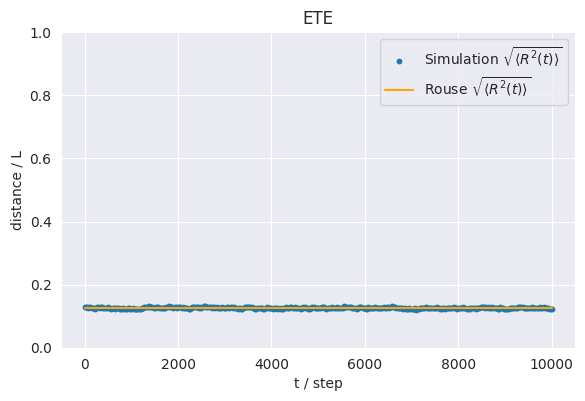

In [19]:
ax: plt.Axes
fig, ax = plt.subplots()

ax.scatter(
    df_ete_mean.index,
    np.sqrt(df_ete_mean["R^2"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle R^2(t) \rangle } $",
    s=10
)

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_R_sq_avg(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b)
    ) / L_contour,
    label=r"Rouse $ \sqrt{ \langle R^2(t) \rangle } $",
    color="orange"
)

ax.legend()

ax.set(
    ylim=(0, 1),
    xlabel="t / step",
    ylabel="distance / L",
    title="ETE"
)

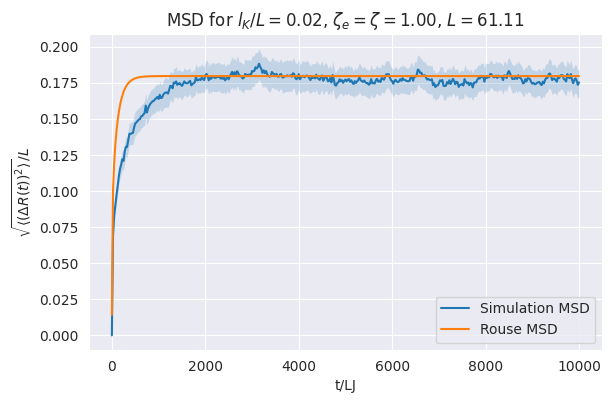

In [20]:
ax: plt.Axes
fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd,
    log_scale=False,
    l_K=L_contour / N_bonds,
    L_contour=L_contour,
    zeta=zeta,
    zeta_e=zeta,
    ax=ax,
    label=r"Simulation MSD"
)

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=tau_rouse,
        p_max=int(N_bonds_rouse))
    ) / L_contour,
    label=r"Rouse MSD"
)

ax.legend()

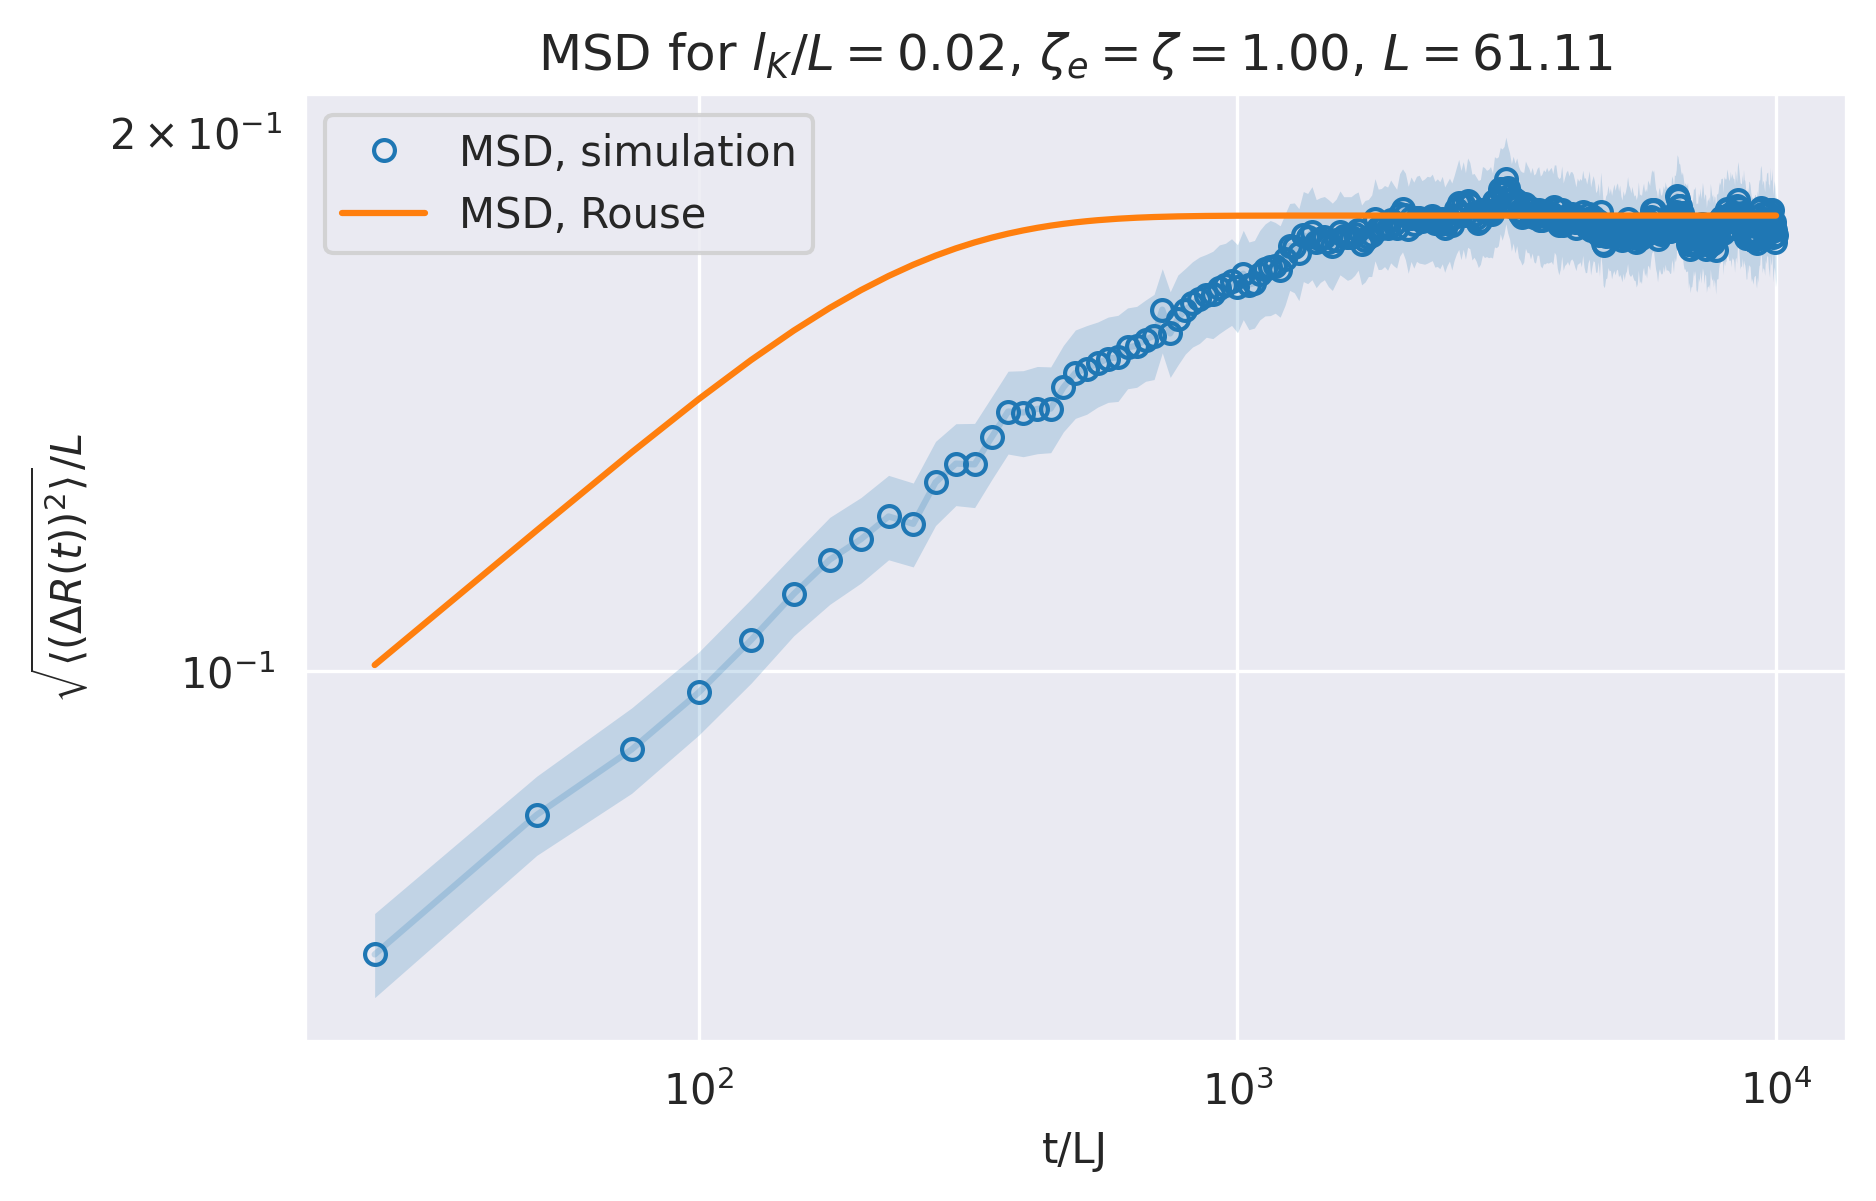

In [44]:
ax: plt.Axes
fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd.iloc[1:],
    log_scale=False,
    l_K=L_contour / N_bonds,
    L_contour=L_contour,
    zeta=zeta,
    zeta_e=zeta,
    ax=ax,
    label=r"MSD, simulation",
    scatter=True,
    color=sns.color_palette()[0]
)

ax.plot(
    df_ete_mean.index[1:],
    np.sqrt(rouse.rouse_g_4(
        t=df_ete_mean.index[1:],
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=tau_rouse,
        p_max=int(N_bonds_rouse))
    ) / L_contour,
    label=r"MSD, Rouse",
    color=sns.color_palette()[1]
)

ax.set(
    xscale="log",
    yscale="log"
)

ax.legend()

## Estimate rouse time from the fit and compare

In [31]:
from functools import partial

popt, pcov = scipy.optimize.curve_fit(
    partial(rouse.rouse_g_4, p_max=N_bonds_rouse, N_b=N_bonds_rouse, l_b=l_b),
    xdata=df_msd["t/LJ"],
    ydata=df_msd["dR^2"],
    p0=tau_rouse,
)
popt, pcov

(array([582.31225811]), array([[90.90198861]]))

In [32]:
t_rouse_fit = popt[0]
dt_rouse_fit = np.sqrt(np.diag(pcov))[0]
print(f"Estimated rouse time (+- 1std err) = {t_rouse_fit} +- {dt_rouse_fit}")

Estimated rouse time (+- 1std err) = 582.3122581066898 +- 9.534253437658489


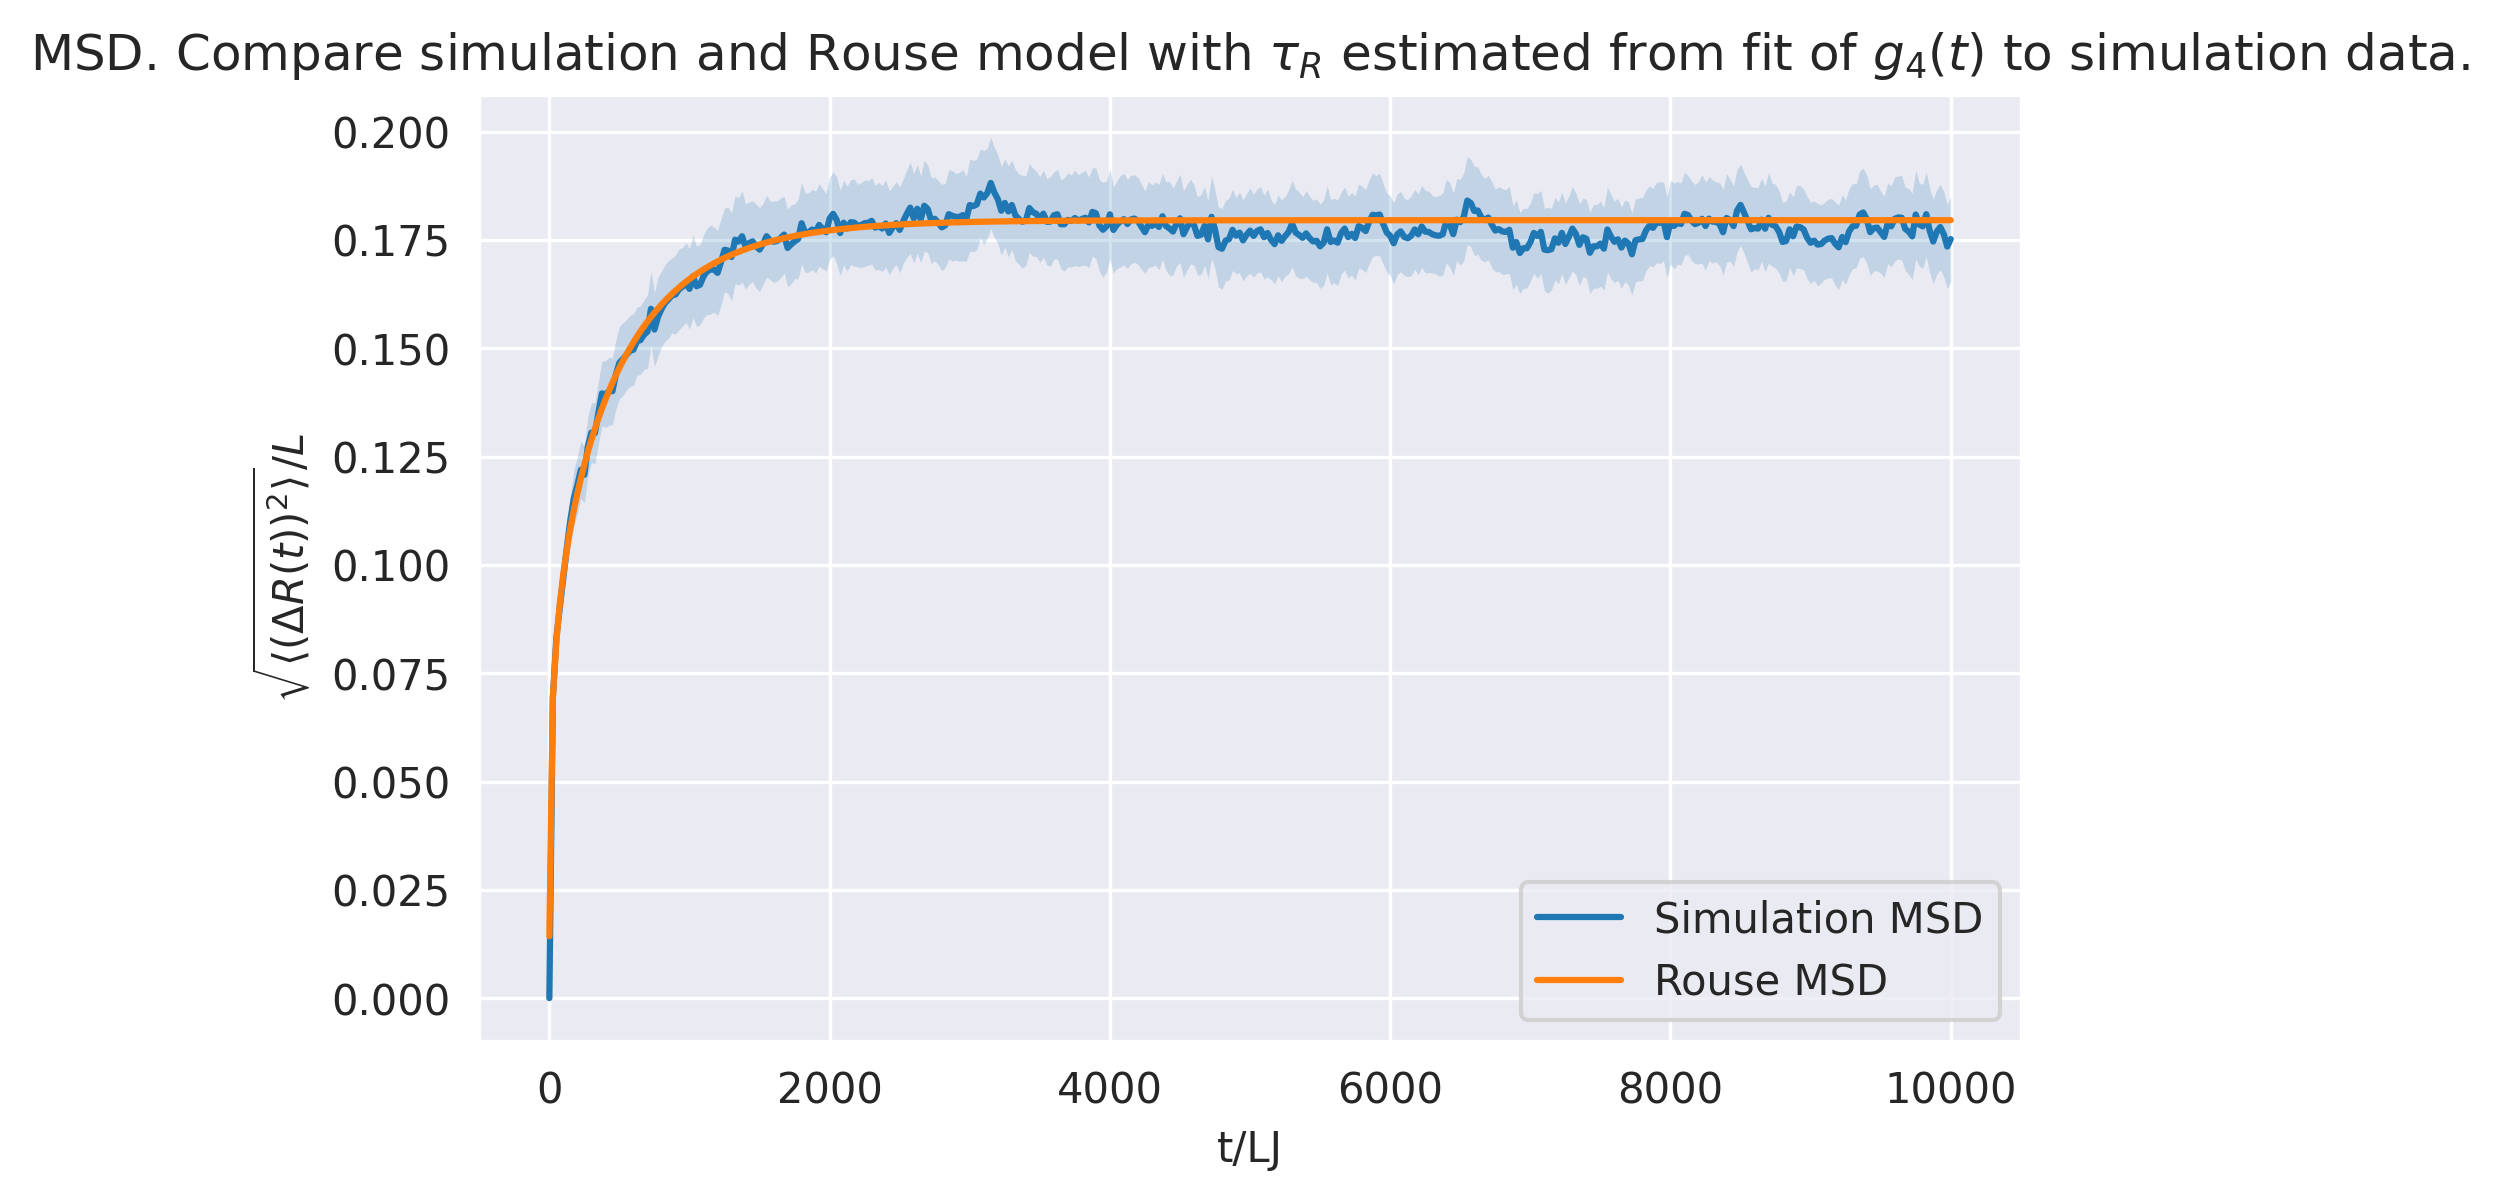

In [33]:
ax: plt.Axes
fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd,
    log_scale=False,
    l_K=L_contour / N_bonds,
    L_contour=L_contour,
    zeta=zeta,
    zeta_e=zeta,
    ax=ax,
    label=r"Simulation MSD"
)

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(
        df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=t_rouse_fit,
        p_max=int(N_bonds_rouse)
    )) / L_contour,
    label=r"Rouse MSD"
)

ax.set_title(
    "MSD. Compare simulation and Rouse model with $\\tau_R$ estimated from fit of $g_4(t)$ to simulation data."
)

ax.legend()

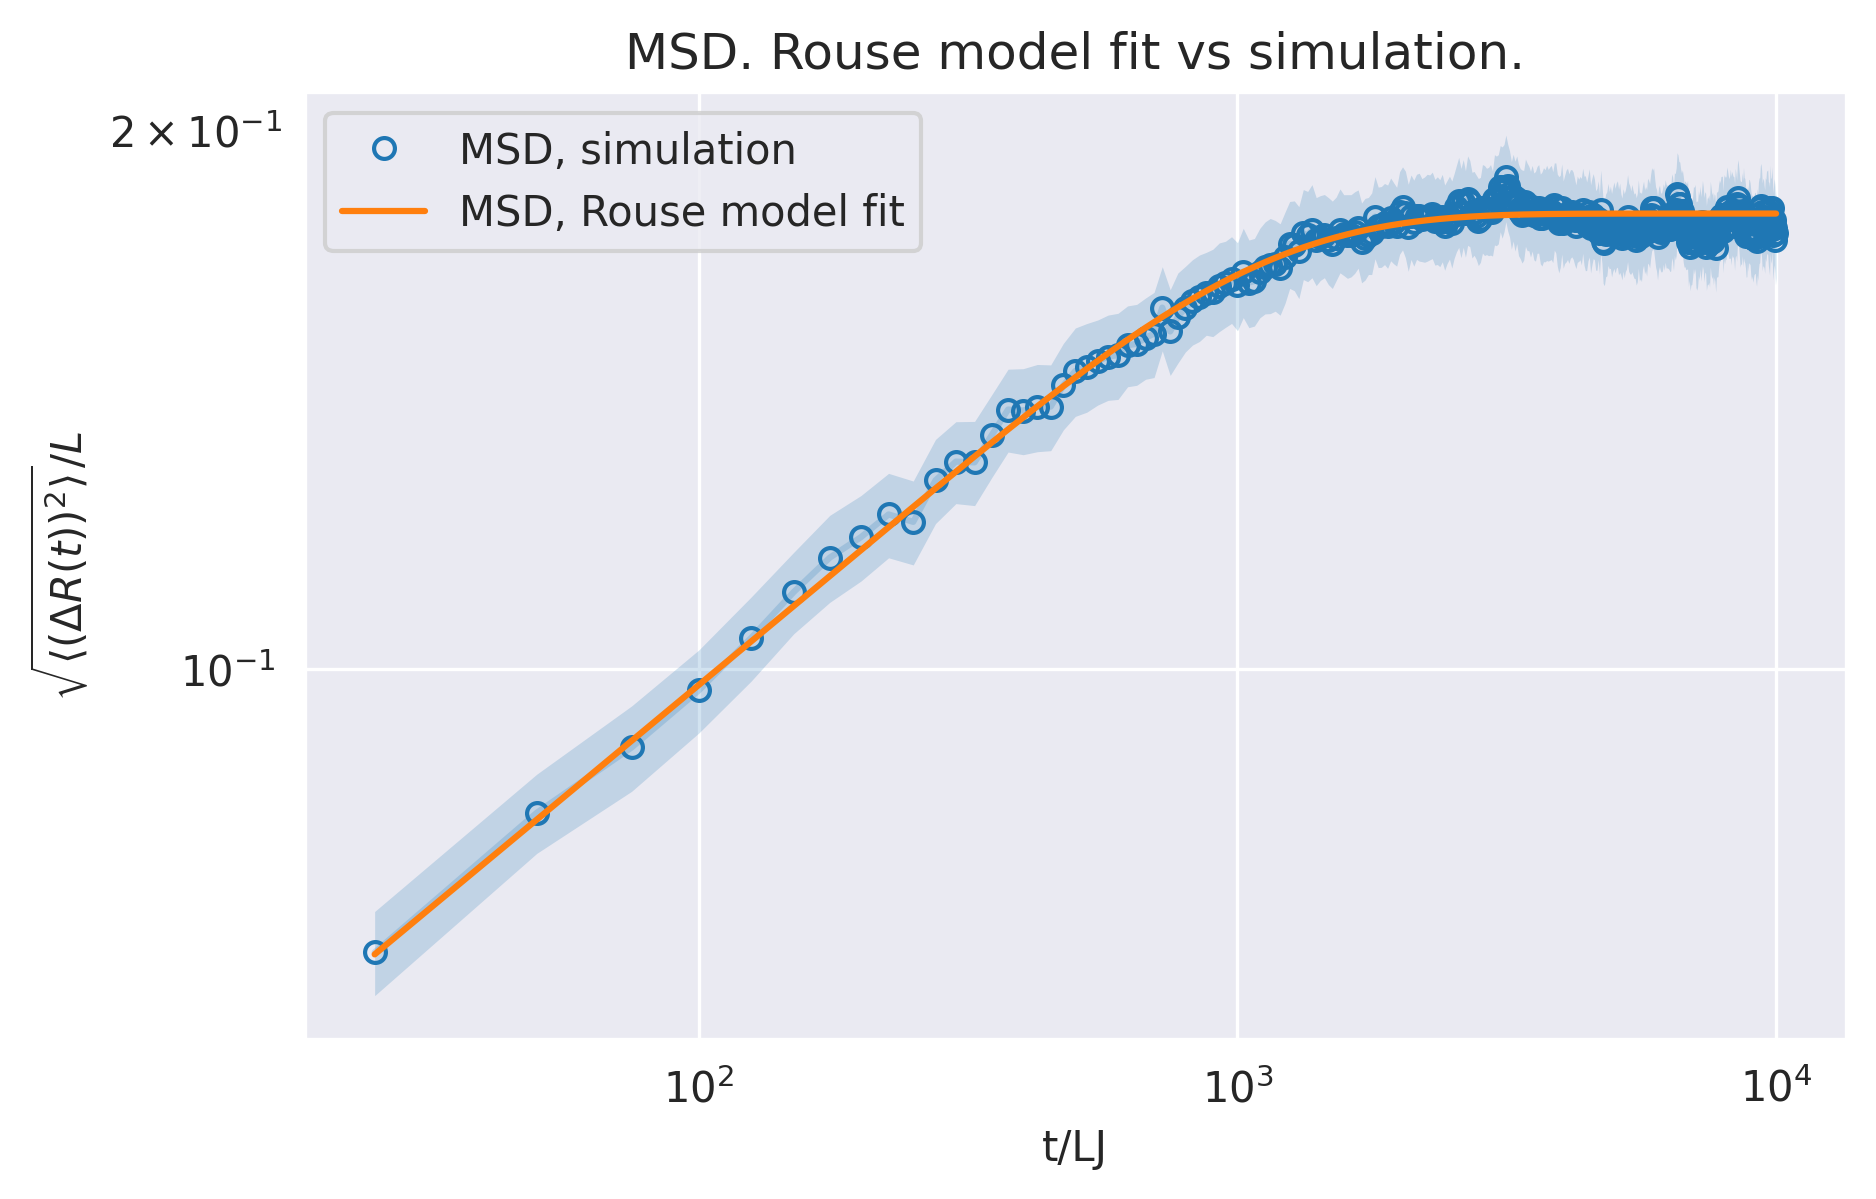

In [48]:
ax: plt.Axes
fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd.iloc[1:],
    log_scale=False,
    l_K=L_contour / N_bonds,
    L_contour=L_contour,
    zeta=zeta,
    zeta_e=zeta,
    ax=ax,
    label=r"MSD, simulation",
    scatter=True,
    color=sns.color_palette()[0]
)

ax.plot(
    df_ete_mean.index[1:],
    np.sqrt(rouse.rouse_g_4(
        df_ete_mean.index[1:],
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=t_rouse_fit,
        p_max=int(N_bonds_rouse)
    )) / L_contour,
    label=r"MSD, Rouse model fit",
    color=sns.color_palette()[1]
)

ax.set(
    xscale="log",
    yscale="log"
)

ax.set_title(
    "MSD. Rouse model fit vs simulation."
)

ax.legend()

### Relaxation time of single bead $\tau_0$

In [26]:
tau_0_theory = rouse.relaxation_time_bead(tau_rouse, N_bonds_rouse)
tau_0_empirical = rouse.relaxation_time_bead(t_rouse_fit, N_bonds_rouse)
d_tau_0_empirical = rouse.relaxation_time_bead(dt_rouse_fit, N_bonds_rouse)

print(f"Empirical: tau_0~={tau_0_empirical:.3f}+-{d_tau_0_empirical:.3f}")
print(f"Theory: tau_0~={tau_0_theory:.3f}")

Empirical: tau_0~=4.209+-0.069
Theory: tau_0~=0.941


### Adjustment factor $\alpha$
$ \alpha = \frac{\tau_{0, \textrm{empirical}}}{\tau_{0, analytical}} $

In [27]:
adjustment_factor_alpha = tau_0_empirical / tau_0_theory
print(f"Estimated Adjustment factor: {adjustment_factor_alpha}")

Estimated Adjustment factor: 4.473768589938356
